## Correcting drift in GEM2 positions


#### Adam Steer, August 2021, adam.d.steer@gmail.com

Sea ice is constantly drifting, so every observation we take on sea ice using GNSS positions needs to be 'drift corrected' in order to show the true spatial relationships between observations. This notebook shows the process of removing drift from airborne camera centre locations, using a reference trajectory from a drifting ice floe.

Operations here are based on code written to translate aircraft trajectories to 'ice floe local' coordinates between 2012 and 2016.

In [1]:
## import the things

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj

In [2]:
## declare useful functions

#perform rotation of an array of 2D coordinates (x,y) about Z axis
def rotate_z(coord, angle):
    r_angle = angle * np.pi/180
    rotmatrix = np.array(((np.cos(r_angle), np.sin(r_angle)), (np.sin(-r_angle), np.cos(r_angle))))
    new_coord = coord * rotmatrix
    return new_coord

def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-0.5
    end = np.max(t2)+0.5
    idx = (t1>=start)*(t1<=end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

In [3]:
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

In [4]:
gnsstrackfile = "/mnt/documents/JC2-2/P9-06092021/gnss/base3-near/kppp/07092021-base3-day2.pos"
gem2inputfile = "/mnt/documents/JC2-2/P9-06092021/gem2/07092021/JC2-2-P9-afternoon-transect-07092021-gem2-531-channel-thickness.csv"

outfilename = "/mnt/documents/JC2-2/P9-06092021/gem2/07092021/p9-afternoon-driftcorrected_gem2_east_north.txt"


OK, functions are declared. next is some messy data gathering (maybe implement using Pandas
                                                              to tidy up next time):

In [5]:
# import pos data from rtklib

gnsstrack = pd.read_csv(gnsstrackfile,
                       skiprows=18)
gnsstrack.keys()

Index(['%  UTC                     ', ' latitude(deg)', 'longitude(deg)',
       ' height(m)', '  Q', ' ns', '  sdn(m)', '  sde(m)', '  sdu(m)',
       ' sdne(m)', ' sdeu(m)', ' sdun(m)', 'age(s)', ' ratio'],
      dtype='object')

In [6]:
gnsstrack["longitude(deg)"].values[0]

7.15307125

In [7]:
gnsstrack[" latitude(deg)"].values[0]

85.499543662

In [8]:
utmzone=getutm(gnsstrack["longitude(deg)"].values[0], gnsstrack[" latitude(deg)"].values[0])
utmzone

[]


IndexError: list index out of range

In [9]:
# set up proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,32631)

In [10]:
#gnssutm=thetransform.transform(gnsstrack["longitude(deg)"].values,gnsstrack[" latitude(deg)"].values)

In [11]:
gnssutm=thetransform.transform(gnsstrack[" latitude(deg)"].values, gnsstrack["longitude(deg)"].values)

In [12]:
gnssutm

(array([536351.96893536, 536351.81706655, 536351.73154919, ...,
        534763.18900052, 534763.12819766, 534763.06964839]),
 array([9496816.57008487, 9496817.18078551, 9496817.28149424, ...,
        9500579.08337877, 9500579.09301527, 9500579.10694983]))

In [13]:
gnsstimes = gnsstrack['%  UTC                     '].values
gnsstimes[0]

'2021/09/07 07:29:19.0000000'

In [14]:
gnssdayseconds=[]
for thetime in gnsstimes:
    hms = thetime[10:]
    hour, minute, second = hms.split(':')
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [15]:
gnssdayseconds = np.array(gnssdayseconds)

In [16]:
gnssdayseconds[0]

26959.0

In [17]:
del(gnsstrack)

In [18]:
# import gem2 data

gem2data = pd.read_csv(gem2inputfile)

In [19]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [75]:
gem2data

time   record_id   longitude   latitude   xc  \
7      2021-09-07T11:31:11.437500           7    7.046150  85.528445  0.0   
8      2021-09-07T11:31:11.539062           8    7.046150  85.528445  0.0   
9      2021-09-07T11:31:11.640625           9    7.046150  85.528445  0.0   
10     2021-09-07T11:31:11.742187          10    7.046150  85.528445  0.0   
11     2021-09-07T11:31:11.835937          11    7.046150  85.528445  0.0   
...                           ...         ...         ...        ...  ...   
31413  2021-09-07T14:01:53.546875       31413    7.012753  85.534289  0.0   
31414  2021-09-07T14:01:53.640625       31414    7.012756  85.534289  0.0   
31415  2021-09-07T14:01:53.750000       31415    7.012760  85.534289  0.0   
31416  2021-09-07T14:01:53.843750       31416    7.012764  85.534289  0.0   
31417  2021-09-07T14:01:53.937500       31417    7.012768  85.534288  0.0   

        yc   f450Hz_hcp_i  f450Hz_hcp_q  f1530Hz_hcp_i  f1530Hz_hcp_q  \
7      0.0          1.885         1.554          1.596          1.518   
8      0.0          0.982         1.648          1.402          1.520   
9      0.0          1.717         1.566          1.447          1.485   
10     0.0          2.112         1.459          1.602          1.483   
11     0.0          2.045         1.502          1.631          1.496   
...    ...            ...           ...            ...            ...   
31413  0.0          2.089         1.521          1.467          1.562   
31414  0.0          1.422         1.482          1.423          1.579   
31415  0.0          1.401         1.582          1.417          1.550   
31416  0.0          1.514         1.551          1.500          1.551   
31417  0.0          2.070         1.459          1.512          1.568   

       f5310Hz_hcp_i  f5310Hz_hcp_q  f18330Hz_hcp_i  f18330Hz_hcp_q  \
7              1.504          1.499           1.507           1.488   
8              1.516          1.503           1.505           1.491   
9              1.528          1.503           1.505           1.495   
10             1.534          1.501           1.505           1.496   
11             1.543          1.502           1.504           1.496   
...              ...            ...             ...             ...   
31413          1.551          1.553           1.558           1.560   
31414          1.550          1.558           1.553           1.558   
31415          1.554          1.558           1.546           1.558   
31416          1.550          1.559           1.550           1.559   
31417          1.555          1.562           1.550           1.562   

       f63030Hz_hcp_i  f63030Hz_hcp_q  
7               1.501           1.484  
8               1.501           1.486  
9               1.501           1.487  
10              1.500           1.488  
11              1.500           1.489  
...               ...             ...  
31413           1.554           1.570  
31414           1.552           1.570  
31415           1.552           1.570  
31416           1.555           1.570  
31417           1.557           1.571  

[31053 rows x 16 columns]

In [78]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [79]:
f1530hz_hcp_i

[1.596,
 1.402,
 1.447,
 1.602,
 1.631,
 1.55,
 1.534,
 1.583,
 1.496,
 1.493,
 1.663,
 1.69,
 1.603,
 1.411,
 1.648,
 1.778,
 1.513,
 1.488,
 1.537,
 1.605,
 1.555,
 1.473,
 1.481,
 1.479,
 1.399,
 1.436,
 1.546,
 1.492,
 1.574,
 1.746,
 1.766,
 1.639,
 1.54,
 1.507,
 1.51,
 1.623,
 1.522,
 1.552,
 1.587,
 1.464,
 1.521,
 1.53,
 1.44,
 1.51,
 1.735,
 1.687,
 1.601,
 1.504,
 1.42,
 1.75,
 1.651,
 1.554,
 1.556,
 1.613,
 1.574,
 1.554,
 1.54,
 1.531,
 1.59,
 1.647,
 1.526,
 1.476,
 1.683,
 1.741,
 1.563,
 1.517,
 1.508,
 1.569,
 1.689,
 1.502,
 1.525,
 1.626,
 1.622,
 1.519,
 1.565,
 1.642,
 1.48,
 1.43,
 1.684,
 1.655,
 1.601,
 1.552,
 1.555,
 1.738,
 1.677,
 1.477,
 1.454,
 1.45,
 1.457,
 1.541,
 1.545,
 1.506,
 1.616,
 1.716,
 1.606,
 1.605,
 1.714,
 1.746,
 1.647,
 1.633,
 1.6,
 1.589,
 1.604,
 1.646,
 1.592,
 1.52,
 1.551,
 1.544,
 1.61,
 1.678,
 1.642,
 1.632,
 1.695,
 1.656,
 1.561,
 1.566,
 1.592,
 1.552,
 1.534,
 1.513,
 1.513,
 1.513,
 1.506,
 1.46,
 1.524,
 1.654,
 1.738,
 1.

In [21]:
gem2data.size

502880

In [22]:
type(gem2data[" f1530Hz_hcp_i"].values)

numpy.ndarray

In [23]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

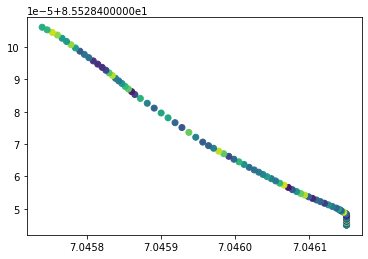

In [80]:
plt.scatter(gem2data[" longitude"].values[0:100], gem2data[" latitude"].values[0:100], c = f1530hz_hcp_i[0:100])

In [25]:
gem2data["time"].values[0]

'2021-09-07T11:31:11.437500'

In [26]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [27]:
gem2utm

(array([535190.66202515, 535190.66202515, 535190.66202515, ...,
        534855.21278375, 534855.2481626 , 534855.28267425]),
 array([9499968.47999449, 9499968.47999449, 9499968.47999449, ...,
        9500598.95448887, 9500598.93457982, 9500598.91461012]))

In [28]:

gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

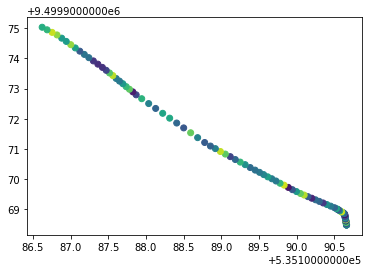

In [81]:
plt.scatter(gem2easting[0:100], gem2northing[0:100], c = f1530hz_hcp_i[0:100])

In [30]:
gem2times = gem2data['time'].values

In [31]:
gem2times[0]

'2021-09-07T11:31:11.437500'

In [32]:
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [33]:
gem2dayseconds = np.array(gem2dayseconds)

In [34]:
gem2dayseconds.size

31053

### get indexes of GPS times which fit the GEM2 time frame

In [35]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

In [36]:
gnss_trimmedtime.size

18087

In [37]:
start

41470.9375

In [38]:
end

50514.4375

### extract GNSS positions which match gem2 times

In [39]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [40]:
trimmedtime.size

18087

In [41]:
trimmedtime[-1]

50514.0

In [42]:
gem2dayseconds[-1]

50513.9375

## interpolate gnss times to gem2 time resolution

ugh, messy... split into four chunks and deal with separately

In [43]:
chunks = [[0,2000],
         [2000,4000],
         [4000,6000],
         [6000, 8000],
         [8000,10000],
         [10000,12000],
         [12000,14000],
         [14000,16000],
         [16000,-1]]


chunkstart=7000
chunkstop=9000

In [44]:
for chunk in chunks:
    print(chunk[1])

2000
4000
6000
8000
10000
12000
14000
16000
-1


In [45]:
gnss_gem2_match_eastings = np.array([])
gnss_gem2_match_northings = np.array([])

In [46]:
np.append(gnss_gem2_match_eastings, [0,1,1])

array([0., 1., 1.])

In [47]:
for chunk in chunks:
    chunkstart = chunk[0]
    chunkstop = chunk[1]
    print('start: {}, stop: {}'.format(chunkstart, chunkstop))
    timesteps = np.arange(trimmedtime[chunkstart], trimmedtime[chunkstop], 0.000001)
    timesteps = np.round(timesteps, 6)
    interp_east = np.interp(timesteps, trimmedtime[chunkstart:chunkstop], trimmedeast[chunkstart:chunkstop])
    interp_north = np.interp(timesteps, trimmedtime[chunkstart:chunkstop], trimmednorth[chunkstart:chunkstop])
    timeindexes= np.where(np.in1d(timesteps, gem2dayseconds))[0]
    
    
    gnss_gem2_match_eastings = np.append(gnss_gem2_match_eastings, interp_east[timeindexes])
    gnss_gem2_match_northings = np.append(gnss_gem2_match_northings, interp_north[timeindexes])
    


start: 0, stop: 2000
start: 2000, stop: 4000
start: 4000, stop: 6000
start: 6000, stop: 8000
start: 8000, stop: 10000
start: 10000, stop: 12000
start: 12000, stop: 14000
start: 14000, stop: 16000
start: 16000, stop: -1


In [62]:
#gnss_gem2_match_eastings3 = interp_east[timeindexes]
#gnss_gem2_match_northings3 = interp_north[timeindexes]

In [54]:
gnss_gem2_match_eastings[0]

535186.533335424

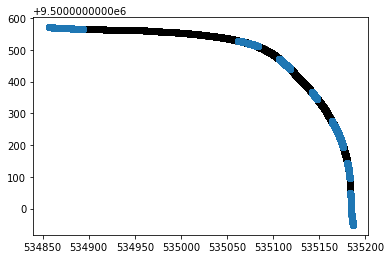

In [48]:
plt.scatter(trimmedeast, trimmednorth, c='black')
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)



In [71]:
"""
gnss_gem2_match_eastings = np.concatenate((gnss_gem2_match_eastings3,
                                           gnss_gem2_match_eastings4,
                                           gnss_gem2_match_eastings5,
                                           gnss_gem2_match_eastings6))
gnss_gem2_match_northings = np.concatenate((gnss_gem2_match_northings3,
                                           gnss_gem2_match_northings4,
                                           gnss_gem2_match_northings5,
                                           gnss_gem2_match_northings6))
                                           """

'\ngnss_gem2_match_eastings = np.concatenate((gnss_gem2_match_eastings3,\n                                           gnss_gem2_match_eastings4,\n                                           gnss_gem2_match_eastings5,\n                                           gnss_gem2_match_eastings6))\ngnss_gem2_match_northings = np.concatenate((gnss_gem2_match_northings3,\n                                           gnss_gem2_match_northings4,\n                                           gnss_gem2_match_northings5,\n                                           gnss_gem2_match_northings6))\n                                           '

In [49]:
np.size(gnss_gem2_match_eastings)

31054

In [50]:
np.size(gem2easting)

31053

In [ ]:
import gc
gc.collect()

## make a timeseries of GNSS positions which match gem2 positions

## test

we should get numbers pretty close together if we take the difference of GNSS and GEM2 positions at the start point

In [55]:
gnss_gem2_match_eastings[1]-gem2easting[0]

-4.129425579565577

In [57]:
gnss_gem2_match_northings[1]-gem2northing[0]

-19.973471695557237

In [58]:
gnss_gem2_match_eastings = gnss_gem2_match_eastings[1:]

In [59]:
gnss_gem2_match_northings = gnss_gem2_match_northings[1:]

## subtract GNSS positions from GEM2 positions to get local positions!

In [60]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

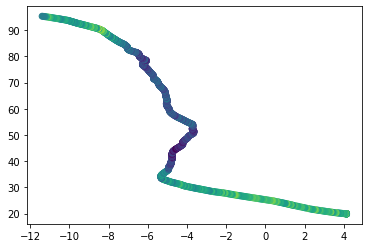

In [82]:
plt.scatter(local_gem2_east[0:1000], local_gem2_north[0:1000], c = f1530hz_hcp_i[0:1000])

## make world positions

...a little bit handrolled, using a world position offset from when the drone was flown

In [63]:
world_east = 524413.58100000
world_north = 9501662.94280000

In [64]:
world_gem2_east= local_gem2_east + world_east
world_gem2_north = local_gem2_north + world_north
world_gem2_east

array([524417.71042558, 524417.71125097, 524417.71207634, ...,
       524412.38976408, 524412.42514293, 524412.45965458])

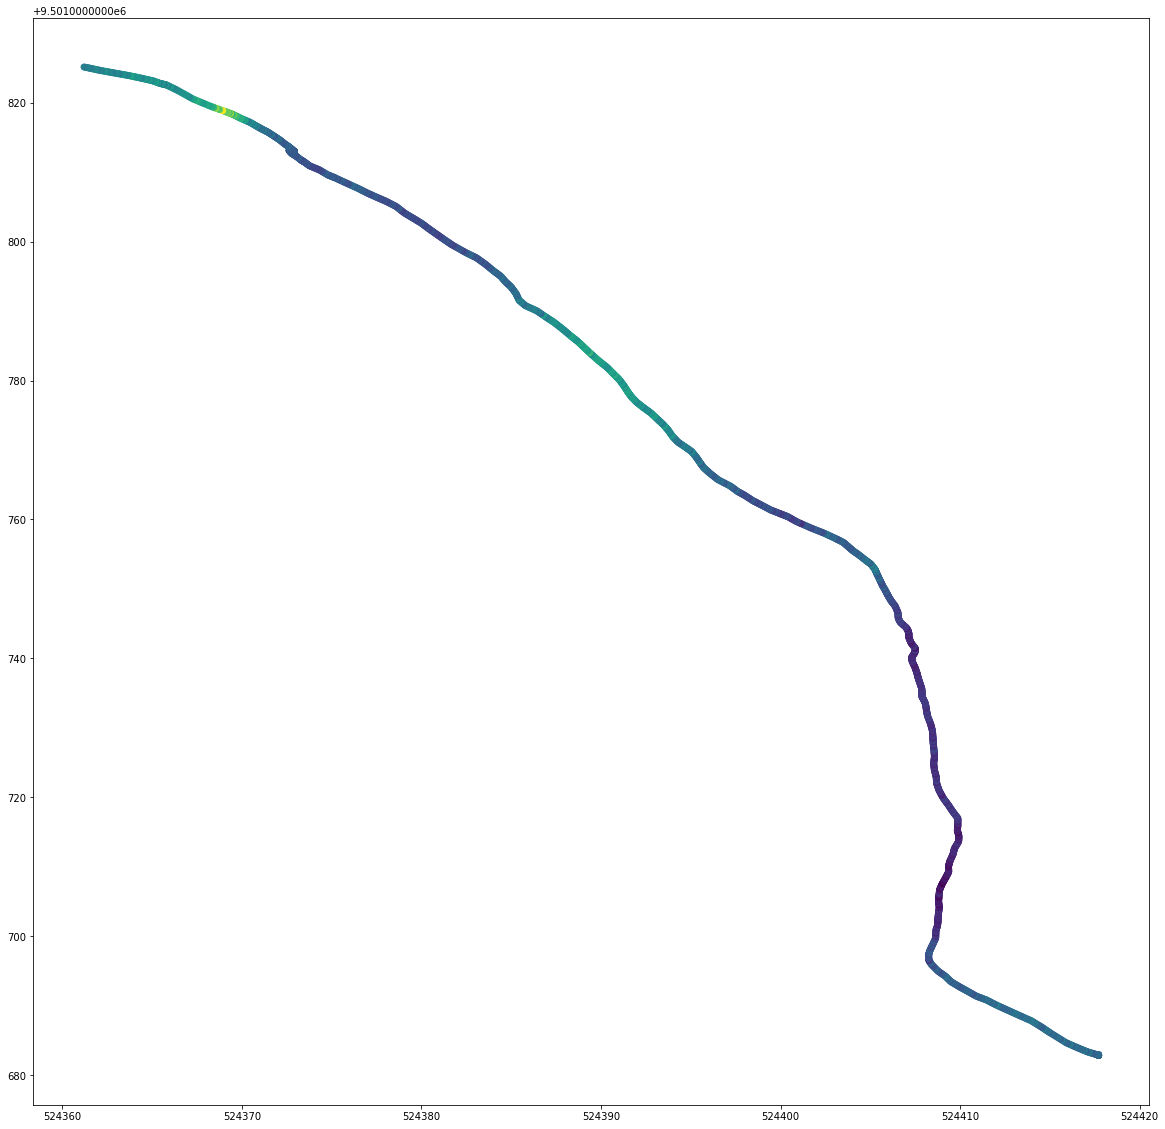

In [84]:
fig = plt.figure(figsize = (20,20))
plt.scatter(world_gem2_east[0:2000], world_gem2_north[0:2000], c = f1530hz_hcp_i[0:2000])

In [85]:
outputarray = np.column_stack((world_gem2_east, world_gem2_north, f1530hz_hcp_i))

In [86]:
outputarray

array([[5.24417710e+05, 9.50168292e+06, 1.59600000e+00],
       [5.24417711e+05, 9.50168290e+06, 1.40200000e+00],
       [5.24417712e+05, 9.50168289e+06, 1.44700000e+00],
       ...,
       [5.24412390e+05, 9.50169068e+06, 1.41700000e+00],
       [5.24412425e+05, 9.50169066e+06, 1.50000000e+00],
       [5.24412460e+05, 9.50169064e+06, 1.51200000e+00]])

In [87]:
np.savetxt(outfilename, outputarray, fmt='%.8f')

# end of GEM2 part

In [ ]:
def getdayseconds(hms, subsecond=None, utc=None):
    
    if utc is not None:
        hours = int(hms[3:5]) - utc
    else:
        hours = int(hms[3:5])
        
    dayseconds = float(int(hms[0:2])*3600.0 + hours*60.0 + float(hms[6:]))
    
    if subsecond is not None:
        subsecond = int(subsecond)
        if subsecond < 100:
            subsecond = subsecond / 100.0
            dayseconds = dayseconds + subsecond
        elif subsecond >= 100:
            subsecond = subsecond / 1000.0
            dayseconds = dayseconds + subsecond
        
    return dayseconds

In [ ]:
gpstimes = basetrajectory.UTC.values

In [ ]:
gpstimes[18478]

In [ ]:
basetrajectory.date[18478]

In [ ]:
basetrajectory.Northing[18478]

In [ ]:
cameracentres.Northing[0] - basetrajectory.Northing[18478]

In [ ]:
gpsdayseconds = []
for i in np.arange(0,len(gpstimes)):
    gpsdayseconds.append(getdayseconds(gpstimes[i]))

In [ ]:
gpsdayseconds = np.array(gpsdayseconds)

In [ ]:
gpsdayseconds

In [ ]:
gps_trimmed,start,end = trim_timeseries(gpsdayseconds, cameradayseconds)

In [ ]:
start

In [ ]:
end

In [ ]:
gps_trimmed = gps_trimmed[0]

In [ ]:
gps_trimmed

In [ ]:
gpsdayseconds[18238]

In [ ]:
gpsdayseconds[21247]

In [ ]:
cameradayseconds[0]

In [ ]:
gpsdayseconds[gps_trimmed]

In [ ]:
gpslat = basetrajectory.Northing
gpslon = basetrajectory.Easting

trimmedlat = np.squeeze(gpslat.values[gps_trimmed])
trimmedlon = np.squeeze(gpslon.values[gps_trimmed])
trimmedtime = np.squeeze(gpsdayseconds[gps_trimmed])

In [ ]:
trimmedtime

In [ ]:
trimmedlat

In [ ]:
timesteps = np.arange(trimmedtime.min(), trimmedtime.max(), 0.001)

In [ ]:
cameradayseconds[0:10]

In [ ]:
timesteps

In [ ]:
trimmedlon[0]

In [ ]:
interp_lat = np.interp(timesteps, trimmedtime, trimmedlat)
interp_lon = np.interp(timesteps, trimmedtime, trimmedlon)

In [ ]:
interp_lat[0:10]

In [ ]:
interp_lon[0:10]

In [ ]:
trimmedtime

### Now to get GPS positions matching camera centres...

In [ ]:
## a dumb way
i=0
timeindexes = []
for thistime in cameradayseconds:
    thistimeindex = np.where(np.round(timesteps[:],3) == thistime)
    timeindexes.append(thistimeindex)
    
            

In [ ]:
timeindexes

In [ ]:
cameradayseconds[0]

In [ ]:
gps_camera_match_lats = interp_lat[timeindexes]
gps_camera_match_lons = interp_lon[timeindexes]

In [ ]:
np.size(np.squeeze(gps_camera_match_lats))

In [ ]:
gps_camera_match_lats = np.squeeze(gps_camera_match_lats)
gps_camera_match_lons = np.squeeze(gps_camera_match_lons)

In [ ]:
#test

gps_camera_match_lons[0]-cameracentres.Easting[0]

In [ ]:
cameracentres.Northing[0]

In [ ]:
timeindexes[0]

In [ ]:
timesteps[711]

In [ ]:
interp_lon[711]

In [ ]:
cameracentres.Easting[0]

### on the home stretch - adjust camera centre positions

In [ ]:
local_camera_east = cameracentres.Easting - gps_camera_match_lons
local_camera_north = cameracentres.Northing - gps_camera_match_lats

In [ ]:
local_camera_east

In [ ]:
#local_camera_north = local_camera_north + cameracentres.Northing[0]
#local_camera_east = local_camera_east + cameracentres.Easting[0]

In [ ]:
np.max(local_camera_north) - np.min(local_camera_north)

In [ ]:
np.max(local_camera_east) - np.min(local_camera_east)

In [ ]:
cameracentres.Easting[0]

In [ ]:
gps_camera_match_lons[0]

In [ ]:
plt.scatter(local_camera_east,local_camera_north)

In [ ]:
world_camera_east= local_camera_east + cameracentres.Easting[0]
world_camera_east

In [ ]:
world_camera_north= local_camera_north + cameracentres.Northing[0]
world_camera_north

In [ ]:
cameracentres_out = np.column_stack((world_camera_east.values, world_camera_north.values))

In [ ]:
outfilename = "../AeN/q2-workingdata/p7/anafiusa/driftcorrected_utm_east_north.txt"

In [ ]:
np.savetxt(outfilename, cameracentres_out, fmt='%.5f')

That's it! The new trajectory is saved, and now we can use it make LiDAR points in the same coordinate
system as the UAV.